# Water Model Calibration

## TODO
- [x] Generate average model
- [x] Network statistics of pipe locations and sensor locations
- [ ] Add ability to track "empty" sensors in order to see sensitivities of different locations as candidates for future sensors
- [ ] Add selection criteria based upon pipes being evaluated
- [ ] Create objective functions, no matter how imperfect
    - [ ] Acceptance Rate
    - [x] Closeness of fit
    - [x] Standard deviation

# Set Up

In [34]:
import wntr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp
import chaospy as cp
from ipypb import track
from matplotlib import cm
import pickle
import datetime as dt
import networkx as nx

# Helper Methods

In [35]:
def savePickle(dataDict,picklePath):
    dataDict["timestamp"] = dt.datetime.now()
    pickle.dump( dataDict, open( picklePath, "wb" ) )

In [36]:
def loadPickle(picklePath):
    dataDict = pickle.load( open( picklePath, "rb" ) )
    return dataDict

In [37]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        elif objType == "Tank":
            objIter = wn.tanks()
        elif objType == "Reservoir":
            objIter = wn.reservoirs()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [38]:
class ResultHelper():
    def __init__(self,results,convertResultsToHours=True):
        self.results = results
        
        # programatically set nodes
        for nodeKey in results.node.keys():
            self.__dict__[nodeKey] = results.node[nodeKey].T
        
        # progrmatically set links
        for linkKey in results.link.keys():
            self.__dict__[linkKey] = results.link[linkKey].T
        
        if convertResultsToHours:
            self.convertResultsToHours()
            
    def help(self):
        return list(self.__dict__.keys())
        
    def convertResultsToHours(self):
        for prop,value in self.__dict__.items():
            if type(value) == pd.DataFrame:
                value.columns = [float(seconds)/3600.0 for seconds in value.columns]
                
    def returnResult(self,resultType,resultLocationID,time):
        if resultType in self.__dict__.keys():
            resultDF = self.__dict__[resultType]
            if resultLocationID in resultDF.index:
                if time in resultDF.columns:
                    return self.__dict__[resultType].loc[resultLocationID][time]
                else:
                    print(f"{time} is not a valid time")
            else:
                print(f"{resultLocationID} is not a valid element in the network")
        else:
            print(f"{resultType} is not a valid property for ResultAnalyzer")
            return None

In [39]:
class Sensor():
    def __init__(self,sensorType,name,sensorSTD,dictOfPropertyValues):
        self.sensorType = sensorType
        self.name = name
        self.sensorSTD = sensorSTD
        self.dictOfPropertyValues = dictOfPropertyValues
        self.dictOfPropertyModelEstimates = {k:[] for k in dictOfPropertyValues.keys()}
        
    def calculateProbability(self,resultHelper):
        p = 1.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(sensorObservationValue,self.sensorSTD)
            p *= distribution.pdf(modelResult)
        return p
    
    def calculateProbability_Summed(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += distribution.pdf(sensorObservationValue)
        return p        
    
    def calculateProbability_Summed_Log(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += np.log(distribution.pdf(sensorObservationValue))
        return p       

In [40]:
class WaterNetworkHelper():
    def __init__(self,wn,name="Water Network"):
        self.wn = wn
        self.updatePipes()
        self.name = name
        self.generateNetworkStatistics()
        
    def updatePipes(self):
        self.pipes = extractDataFrame(self.wn).set_index("name")
        self.nodes = extractDataFrame(self.wn,"Junction").set_index("name")
        self.tanks = extractDataFrame(self.wn,"Tank").set_index("name")
        self.reservoirs = extractDataFrame(self.wn,"Reservoir").set_index("name")
        
    def setPipeDiameter(self,pipeID,newDiameter):
        pipe = self.wn.get_link(pipeID)
        pipe.diameter = newDiameter
        self.updatePipes()
    
    def setPipeRoughness(self,pipeID,newRoughness):
        pipe = self.wn.get_link(pipeID)
        pipe.roughness = newRoughness
        self.updatePipes()
    
    def setPipeStatus(self,pipeID,newStatus):
        pipe = self.wn.get_link(pipeID)
        pipe.status = newStatus
        self.updatePipes()
        
    def generateNetworkStatistics(self):
        pipes = self.pipes
        G = self.wn.get_graph()
        nodeDegrees = G.degree()
        linkBridges = G.bridges()
        terminalNodes = G.terminal_nodes()
        nodeDegreeCentralities = nx.degree_centrality(G)
        nodeCurrentFlowBetweennessCentralities = nx.current_flow_betweenness_centrality(G.to_undirected())
        nodeLoadCentralities = nx.load_centrality(G)

        currentRank = 0
        voteRankOrders = {}
        for i,orderedVoteRank in enumerate(nx.voterank(G.to_undirected())):
            voteRankOrders[orderedVoteRank] = currentRank
            currentRank += 1
        # add nodes with no rank, in arbitrary list order
        for node in list(G.nodes):
            if node not in voteRankOrders.keys():
                voteRankOrders[node] = currentRank
                currentRank += 1

        start_node_degrees = []
        end_node_degrees = []
        highest_node_degrees = []

        link_is_bridges = []

        includes_terminal_nodes = []

        start_node_degree_centralities = []
        end_node_degree_centralities = []
        highest_node_degree_centralities = []

        start_node_current_flow_betweenness_centralities = []
        end_node_current_flow_betweenness_centralities = []
        highest_node_current_flow_betweenness_centralities = []

        start_node_vote_rank_orders = []
        end_node_vote_rank_orders = []
        highest_node_vote_rank_orders = []

        start_node_degree_load_centralities = []
        end_node_degree_load_centralities = []
        highest_node_degree_load_centralities = []

        for pipe,row in pipes.iterrows():
            start_node_name = row["start_node_name"]
            end_node_name = row["end_node_name"]
            
            # Node degree
            start_node_degrees.append(nodeDegrees[start_node_name])
            end_node_degrees.append(nodeDegrees[end_node_name])
            highest_node_degrees.append(max(nodeDegrees[start_node_name],nodeDegrees[end_node_name]))

            # Link bridges
            if pipe in linkBridges:
                link_is_bridges.append(True)
            else:
                link_is_bridges.append(False)
            # Terminal Nodes
            if start_node_name in terminalNodes or end_node_name in terminalNodes:
                includes_terminal_nodes.append(True)
            else:
                includes_terminal_nodes.append(False)

            # Node degree centralities
            start_node_degree_centralities.append(nodeDegreeCentralities[start_node_name])
            end_node_degree_centralities.append(nodeDegreeCentralities[end_node_name])    
            highest_node_degree_centralities.append(max(nodeDegreeCentralities[start_node_name],nodeDegreeCentralities[end_node_name]))

            # Node current flow betweenness centralities
            start_node_current_flow_betweenness_centralities.append(nodeCurrentFlowBetweennessCentralities[start_node_name])
            end_node_current_flow_betweenness_centralities.append(nodeCurrentFlowBetweennessCentralities[end_node_name])
            highest_node_current_flow_betweenness_centralities.append(max(nodeCurrentFlowBetweennessCentralities[start_node_name],nodeCurrentFlowBetweennessCentralities[end_node_name]))

            # Node vote rank orders
            start_node_vote_rank_orders.append(voteRankOrders[start_node_name])
            end_node_vote_rank_orders.append(voteRankOrders[end_node_name])
            highest_node_vote_rank_orders.append(min(voteRankOrders[start_node_name],voteRankOrders[end_node_name]))

            # Load centralities
            start_node_degree_load_centralities.append(nodeLoadCentralities[start_node_name])
            end_node_degree_load_centralities.append(nodeLoadCentralities[end_node_name])
            highest_node_degree_load_centralities.append(max(nodeLoadCentralities[start_node_name],nodeLoadCentralities[end_node_name]))

        pipes["start_node_degree"] = start_node_degrees
        pipes["end_node_degree"] = end_node_degrees
        pipes["link_is_bridge"] = link_is_bridges
        pipes["includes_terminal_node"] = includes_terminal_nodes
        pipes["start_node_degree_centrality"] = start_node_degree_centralities
        pipes["end_node_degree_centrality"] = end_node_degree_centralities
        pipes["start_node_current_flow_betweenness_centrality"] = start_node_current_flow_betweenness_centralities
        pipes["end_node_current_flow_betweenness_centrality"] = end_node_current_flow_betweenness_centralities
        pipes["start_node_vote_rank_order"] = start_node_vote_rank_orders
        pipes["end_node_vote_rank_order"] = end_node_vote_rank_orders
        pipes["start_node_degree_load_centrality"] = start_node_degree_load_centralities
        pipes["end_node_degree_load_centrality"] = end_node_degree_load_centralities

        pipes["highest_node_degree"] = highest_node_degrees
        pipes["highest_node_degree_centrality"] = highest_node_degree_centralities
        pipes["highest_node_current_flow_betweenness_centrality"] = highest_node_current_flow_betweenness_centralities
        pipes["highest_node_vote_rank_order"] = highest_node_vote_rank_orders
        pipes["highest_node_degree_load_centrality"] = highest_node_degree_load_centralities
            
    def runSimulation(self):
        sim = wntr.sim.EpanetSimulator(self.wn)
        results = ResultHelper(sim.run_sim())
        return results        
    
    def plotNetwork(self,figsize=(10,10),link_attribute=None,node_attribute=None):
        fig,ax = plt.subplots(figsize=figsize)
        wntr.graphics.plot_network(self.wn, title=self.name,ax=ax,node_attribute=node_attribute,link_attribute=link_attribute)

In [69]:
class Calibrator():
    def __init__(self,elementName,elementProperty,distribution,trueValue=None):
        self.elementName = elementName
        self.elementProperty = elementProperty
        self.prior = distribution # type of distribution
        self.values = []
        self.proposedValues = []
        self.trueValue = trueValue
        
    def generateProposal(self):
        return self.prior.rvs()
    
    def generateTransition(self,currentValue=None,σ=None):
        if not currentValue:
            currentValue = self.values[-1]
        if not σ:
            σ = self.prior.std()
        # simple gaussian case
        dist = stats.norm(currentValue,σ)
        return dist.rvs()
    
    def calculateProbability(self,value):
        return self.prior.pdf(value)
    
    def calculateProbability_Transition(self,value):
        dist = stats.norm(self.values[-1],self.prior.std())
        return dist.pdf(value)
    
    def fitDistribution(self,dist=stats.norm):
        params = dist.fit(calibrator.values)
        return params
        
    def setValue(self,waterNetworkHelper,newValue):
        if self.elementProperty == "diameter":
            waterNetworkHelper.setPipeDiameter(self.elementName,newValue)
        elif self.elementProperty == "roughness":
            waterNetworkHelper.setPipeRoughness(self.elementName,newValue)
        elif self.elementProperty == "status":
            waterNetworkHelper.setPipeStatus(self.elementName,newValue)
            
    def setValueToResult(self,waterNetworkHelper,resultMetric="mean",burnin=0.0):
        resultWithBurnin = self.values[int(burnin*len(self.values)):]
        result = np.mean(resultWithBurnin)
        if resultMetric == "median":
            result = np.median(resultWithBurnin)
        
        self.setValue(waterNetworkHelper,result)
            
    def plot(self,trueValue,burnin=0.0,ax=None,acceptanceRate=None):
        columnName = f"{self.elementName} {self.elementProperty}"
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratorDFToPlot = pd.DataFrame({columnName:valuesSubset})
        if not ax:
            fig,ax = plt.subplots(figsize=(10,10))
        calibratorDFToPlot.plot(kind="hist",ax=ax,legend=False,density=True)
        ax.axvline(trueValue,color="red",ls="--",label="True Value")
        title = f'{columnName}\nCalibrated Mean: {calibratorDFToPlot[columnName].mean():.1f}, Calibrated Median: {calibratorDFToPlot[columnName].median():.1f}\nTrue Value: {trueValue:.1f}, Prior Mean: {self.prior.mean():.1f}'
        if acceptanceRate:
            title += f"\nAcceptance Rate: {acceptanceRate*100.0:.2f}%"
        scores = self.score(burnin=burnin)
        title += f'\nPercent Difference: {scores["Fraction Difference"]*100.0:.2f}%, STD: {scores["Standard Deviation"]:.2f}'
        ax.set_title(title)
        ax.set_xlabel(self.elementProperty)
        
        # add the prior distribution
        priorEstimates = []
        
        lspace = np.linspace(0,220,10000)
        ns = self.prior.pdf(lspace)
        sns.lineplot(lspace,ns,ax=ax,color="orange",alpha=0.2,label="Prior")
        ax.fill_between(lspace,ns, color="orange", alpha=0.1)
        
#         for i in range(0,10000):
#             priorEstimates.append(self.generateProposal())
#         priorEstimatesDF = pd.DataFrame({"Prior":priorEstimates})
#         priorEstimatesDF.plot(kind="hist",ax=ax,color="orange",alpha=0.1,label="Prior",density=True)
        return ax

    def plotParameterValues(self,burnin=0.0,ax=None):
        if not ax:
            fig,ax = plt.subplots(figsize=(10,10))
        pd.DataFrame({"Accepted Values":self.values}).plot(kind="line",ax=ax,label="Accepted Values")
        pd.DataFrame({"Proposed Values":self.proposedValues}).plot(kind="line",ax=ax,color="grey",alpha=0.1,label="Proposed Values")
        ax.axhline(self.trueValue,ls="--",color="red",label="True Value")
        ax.set_title(f"{self.elementName} {self.elementProperty}");
        ax.axvspan(0,int(burnin*len(self.values)),alpha=0.05,color="red",label="Burn In Discard Range")
        ax.legend()
        return ax
        

    def plotRollingAverage(self,trueValue,burnin=0.0,ax=None,pointAlpha=0.1):
        if not ax:
            fig,ax = plt.subplots(figsize=(10,5))
            
        rollingAverages = []
        for i in range(1,len(self.values)):
            rollingAverages.append(np.mean(self.values[0:i]))
        sns.lineplot(range(1,len(self.values)),rollingAverages,ax=ax)
        ax.set_title(f"{self.elementName} {self.elementProperty} Rolling Average")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(self.elementProperty)
        ax.axhline(trueValue,ls="--",alpha=0.1,color="red")
        sns.scatterplot(range(0,len(self.proposedValues)),self.proposedValues,marker="x",color="grey",alpha=pointAlpha,ax=ax)
        return ax
    
    def plotRollingSTD(self,trueValue,burnin=0.0,ax=None):
            if not ax:
                fig,ax = plt.subplots(figsize=(10,5))
                
            rollingStds = []
            for i in range(1,len(self.values)):
                rollingStds.append(np.std(self.values[0:i]))
            sns.lineplot(range(1,len(self.values)),rollingStds,ax=ax)
            ax.set_title(f"{self.elementName} {self.elementProperty} Rolling Standard Deviation")
            ax.set_xlabel("Iteration")
            ax.set_ylabel(self.elementProperty)
            return ax
        
    def score(self,burnin=0.5):
        scores = {}
        
        # Calculate fraction difference
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratedValue = np.mean(valuesSubset)
        if self.trueValue != 0:
            fractionDifference = abs(calibratedValue - self.trueValue) / self.trueValue
        else:
            fractionDifference = "undefined"
        scores["Fraction Difference"] = fractionDifference
        
        # Calculate standard deviation
        scores["Standard Deviation"] = np.std(valuesSubset)
        return scores

# Methods for Markov Chain Monte Carlo

In [42]:
def π_Transition(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateTransition()
        estimatesDict[calibrator] = rv
    return estimatesDict             

In [43]:
"""
This function generates the random numbers for the parameters being tested
"""
def π(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateProposal()
        estimatesDict[calibrator] = rv
    return estimatesDict     

In [44]:
"""
This function calculates the probability that the parameters are 
pulled from their distribution
"""
def π_Prior(estimatesDict):
    p = 1.0
    for calibrator,parameterValue in estimatesDict.items():
#         pi = calibrator.calculateProbability(parameterValue)
        pi = calibrator.calculateProbability_Transition(parameterValue)
        p *= pi
    return p

In [45]:
"""
This function loops through a set of observations and calculates the
log-liklihood of each, summed
"""
def π_Log_Liklihood(listOfSensors,modelResult):
    logLiklihood = 0.0
    for sensor in listOfSensors:
        logLiklihood += sensor.calculateProbability_Summed_Log(modelResult)
#         logLiklihood += sensor.calculateProbability_Summed(modelResult)
#     logLiklihood = np.log(logLiklihood)
    return logLiklihood

In [46]:
def setParameterValues(proposedParameters):
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.values.append(proposedParameterValue)

In [47]:
def generateRandomCalibrators(waterNetwork,pAddCalibrator=0.05,calibrationParameter="roughness"):
    listOfCalibrators = []
    pAddCalibrator = 0.05
    for i,row in waterNetwork.pipes.iterrows():
        rand = np.random.random()
        if rand < pAddCalibrator:
            actualRoughness = row["roughness"]
            dist = stats.norm(actualRoughness,calibratorSTD)
            randomRoughness = dist.rvs()
            prior = stats.norm(randomRoughness,calibratorSTD)
            calibrator = Calibrator(i,"roughness",prior,trueValue=actualRoughness)
            listOfCalibrators.append(calibrator)
    return listOfCalibrators

In [48]:
def generateRandomSensors(waterNetwork,pAddSensor=0.2,sensorProperty="flowrate",timesToAdd=[1.00,2.25,5.00],sensorSTD=0.001):
    listOfSensors = []
    testResult = waterNetwork.runSimulation()
    for i,row in testResult.flowrate.iterrows():
        rand = np.random.random()
        if rand < pAddSensor:
            sensorProperty = "flowrate"
            sensorName = i
            sensorDict = {}
            for time in testResult.pressure.columns:
                if time in timesToAdd:
                    sensorDict[time] = row[time]
            sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
            listOfSensors.append(sensor)
    return listOfSensors

In [49]:
def generateListOfCalibrators(waterNetwork,listOfCalibratorLocations,calibrationParameter="roughness",calibratorSTD=30):
    listOfCalibrators = []
    for i,row in waterNetwork.pipes.iterrows():
        if i in listOfCalibratorLocations:
            actualRoughness = row["roughness"]
            dist = stats.norm(actualRoughness,calibratorSTD)
            randomRoughness = dist.rvs()
            prior = stats.norm(randomRoughness,calibratorSTD)
            calibrator = Calibrator(i,"roughness",prior,trueValue=actualRoughness)
            listOfCalibrators.append(calibrator)
    return listOfCalibrators

In [50]:
def generateListOfSensors(waterNetwork,listOfSensorLocations,sensorProperty="flowrate",timesToAdd=[1.00,2.25,5.00],sensorSTD=0.001):
    listOfSensors = []
    testResult = waterNetwork.runSimulation()
    for i,row in testResult.flowrate.iterrows():
        if i in listOfSensorLocations:
            sensorProperty = "flowrate"
            sensorName = i
            sensorDict = {}
            for time in testResult.pressure.columns:
                if time in timesToAdd:
                    sensorDict[time] = row[time]
            sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
            listOfSensors.append(sensor)
    return listOfSensors

In [51]:
def MCMC(waterNetwork,calibrators,sensors,nIterations=1000):
    dataDict = {}
    iterations = []
    acceptanceRatios = []
    isAccepted = []
    
    currentParameters = π(listOfCalibrators)
    for calibrator,proposedParameterValue in currentParameters.items():
        calibrator.values.append(proposedParameterValue)
        calibrator.setValue(waterNetwork,proposedParameterValue)
    currentModelResult = waterNetwork.runSimulation()
    
    for i in track(range(0,nIterations)):
        iterations.append(i)

        # generate a set of proposed values as a starting point
        proposedParameters = π_Transition(listOfCalibrators)
        for calibrator,proposedParameterValue in proposedParameters.items():
            calibrator.proposedValues.append(proposedParameterValue)
            # udpate the model
            calibrator.setValue(waterNetwork,proposedParameterValue)

        # run the model
        try:
            modelResult = waterNetwork.runSimulation()

            # calculate the acceptance probabilities
            α_1 = 0 #np.log(π_Prior(proposedParameters))
            α_2 = π_Log_Liklihood(listOfSensors,modelResult)
            α_3 = 0 #np.log(π_Prior({calibrator:calibrator.values[-1] for calibrator in listOfCalibrators}))
            α_4 = π_Log_Liklihood(listOfSensors,currentModelResult)
            α = np.exp(α_1 + α_2 - α_3 - α_4)
            α = min(1.0,α)
            acceptanceRatios.append(α)
            accepted = False

            # decide if we accept
            if α == 1: # accept
                setParameterValues(proposedParameters)
                currentParameters = proposedParameters
                currentModelResult = modelResult
                accepted = True
            else: # draw a random number and take the probability based on α
                rand = np.random.random()
                if rand < α: # accept
                    setParameterValues(proposedParameters)
                    currentParameters = proposedParameters
                    currentModelResult = modelResult
                    accepted = True
                else:
                    setParameterValues(currentParameters)

            # update our iteration
            # update parameter histories
            isAccepted.append(accepted)
        except:
            # model failed
            pass

    dataDict["iterations"] = iterations
    dataDict["acceptanceRatios"] = acceptanceRatios
    dataDict["isAccepted"] = isAccepted
    dataDict["calibrators"] = listOfCalibrators
    dataDict["sensors"] = listOfSensors
    dataDict["model"] = waterNetwork
    return dataDict

In [52]:
def GA():
    return None

# Functions to Plot Results

In [53]:
def generateResultingModel(waterNetwork,listOfCalibrators,burnin=0.25,resultMetric="mean"):
    for calibrator in listOfCalibrators:
        calibrator.setValueToResult(waterNetwork,burnin=burnin,resultMetric=resultMetric)
    results = waterNetwork.runSimulation()
    return results

In [54]:
def plotDifferencesInResults(resultsDict,time=5.00,burnin=0.2,resultMetric="mean"):
    # set up the actual model
    listOfCalibrators = resultsDict["calibrators"]
    isAccepted = resultsDict["isAccepted"]
    waterNetwork = resultsDict["model"]
    
    for calibrator in listOfCalibrators:
        calibrator.setValue(waterNetwork,calibrator.trueValue)
    actualModelResults = waterNetwork.runSimulation()
    
    # set up the calibrated model
    calibratedModelResults = generateResultingModel(waterNetwork,listOfCalibrators)
    
    # plot the results
    fig,ax = plt.subplots(figsize=(20,5))
    (actualModelResults.flowrate[time] - calibratedModelResults.flowrate[time]).plot(ax=ax,kind="bar")
    ax.set_title(f"Actual Differences in Link Flow Rates at Hour {time}\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)} of {len(isAccepted)} Iterations");

In [55]:
def plotDetailedCalibratorResults(listOfCalibrators,burnin=0.5,figsize=(20,20),savePath=None,pointAlpha=0.2):
    for calibrator in listOfCalibrators:
        fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=figsize)
        calibrator.plot(calibrator.trueValue,burnin=burnin,ax=ax1)
        calibrator.plotRollingAverage(calibrator.trueValue,burnin=burnin,ax=ax2,pointAlpha=pointAlpha)
        calibrator.plotRollingSTD(calibrator.trueValue,burnin=burnin,ax=ax3)
        calibrator.plotParameterValues(burnin=burnin,ax=ax4)
    
    if savePath:
        fig.savefig(savePath)
    return (ax1,ax2,ax3)

In [56]:
def plotCalibratorResults(listOfCalibrators,burnin=0.2,figsize=(22,7),savePath=None,pointAlpha=0.2,acceptanceRate=None):
    for calibrator in listOfCalibrators:
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=figsize)
        calibrator.plot(calibrator.trueValue,burnin=burnin,ax=ax1,acceptanceRate=acceptanceRate)
        calibrator.plotRollingAverage(calibrator.trueValue,burnin=burnin,ax=ax2,pointAlpha=pointAlpha)
        calibrator.plotRollingSTD(calibrator.trueValue,burnin=burnin,ax=ax3)
    if savePath:
        fig.savefig(savePath)
    return (ax1,ax2,ax3)

In [57]:
def plotNetworkSetup(resultsDict,burnIn=0.25):
    iterations = resultsDict["iterations"]
    acceptanceRatios = resultsDict["acceptanceRatios"]
    isAccepted = resultsDict["isAccepted"]
    listOfCalibrators = resultsDict["calibrators"]
    listOfSensors = resultsDict["sensors"]
    waterNetwork = resultsDict["model"]
    
    fig,ax = plt.subplots(figsize=(20,10))
    dict_sensors = {}
    dict_trueValues = {}
    for sensor in listOfSensors:
        dict_sensors[sensor.name]=sensor.dictOfPropertyModelEstimates[5.00][int(burnIn*len(sensor.dictOfPropertyModelEstimates[5.00])):len(sensor.dictOfPropertyModelEstimates[5.00])+1]
        dict_trueValues[sensor.name] = [sensor.dictOfPropertyValues[5.00]]
    df_sensors = pd.DataFrame(dict_sensors)
    sns.boxplot(data=df_sensors,ax=ax)
    # df_sensors.plot(kind="box",ax=ax)
    df_true = pd.DataFrame(dict_trueValues)
    df_true.T.plot(ax=ax,kind="bar",alpha=0.1)
    n=100
    ax.set_title(f"Sensor Ranges Compared to True Values\n{burnIn*100:.1f}% Burn In After {n} Iterations\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)*100:.1f}%")


    baseNetwork = wntr.network.WaterNetworkModel(inp_file)
    calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
    sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

    allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

    calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
    sensorPipes = [sensor.name for sensor in listOfSensors]

    for control in list(calibratorNetwork.controls()):
        try:
            calibratorNetwork.remove_control(control[0])
            sensorNetwork.remove_control(control[0])
        except:
            print(f"error removing {control[0]}")
            pass

    for pipe in allPipes:
        if pipe not in calibratorPipes:
            try:
                calibratorNetwork.remove_link(pipe)
            except:
                print(f"could not remove {pipe} from calibrators")
        if pipe not in sensorPipes:
            try:
                sensorNetwork.remove_link(pipe)
            except:
                print(f"could not remove {pipe} from sensors")

    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
    wntr.graphics.plot_network(baseNetwork,link_alpha=1.0,node_alpha=0.1,ax=ax1,link_labels=True)
    wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax2,link_labels=False)
    wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax3,link_labels=False)
    wntr.graphics.plot_network(calibratorNetwork,ax=ax2,node_alpha=0.0,link_labels=True,link_width=5,link_cmap=cm.autumn)
    wntr.graphics.plot_network(sensorNetwork,ax=ax3,node_alpha=0.0,link_labels=True,link_width=5)
    fig.suptitle("Sensor and Calibrator Arrangement")
    ax1.set_title("Overall Network")
    ax2.set_title("Network Elements Being Calibrated")
    ax3.set_title("Sensor Locations")

# MCMC Run

(<matplotlib.collections.PathCollection at 0x2164425d0c8>,
 <matplotlib.collections.LineCollection at 0x2164425d748>)

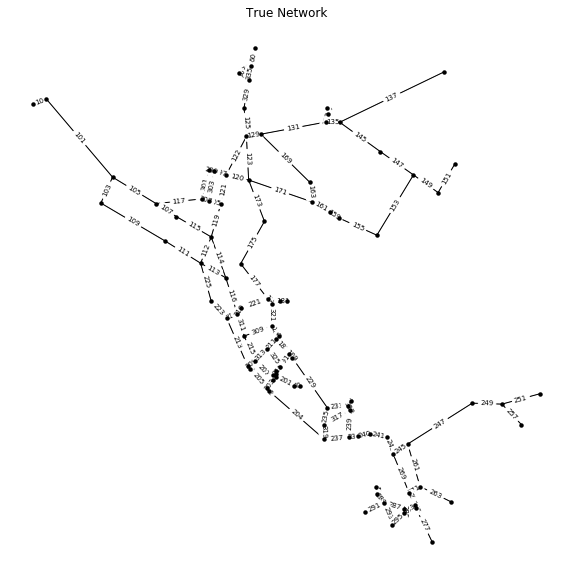

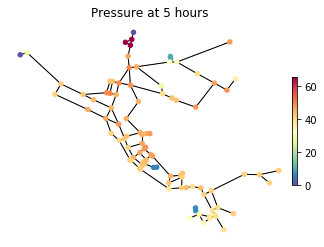

In [63]:
# Set up the known network
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

# Graph the network
fig,ax = plt.subplots(figsize=(10,10))
wntr.graphics.plot_network(wn_true, title="True Network",link_labels=True,ax=ax)

# Simulate hydraulics
sim_true = wntr.sim.EpanetSimulator(wn_true)
results_true = sim_true.run_sim()

# Plot results on the network
pressure_at_5hr = results_true.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn_true, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [26]:
wntr.graphics.plot_leaflet_network(wn_true,filename="testleaflet.html")

# Selecting sensor locations

In [27]:
waterNetwork.pipes

,bulk_rxn_coeff,cv,diameter,end_node,end_node_name,flow,initial_setting,initial_status,length,link_type,...,end_node_current_flow_betweenness_centrality,start_node_vote_rank_order,end_node_vote_rank_order,start_node_degree_load_centrality,end_node_degree_load_centrality,highest_node_degree,highest_node_degree_centrality,highest_node_current_flow_betweenness_centrality,highest_node_vote_rank_order,highest_node_degree_load_centrality
name,,,,,,,,,,,,,,,,,,,,,
20,None,False,2.5146,20,20,None,None,1,30.1752,Pipe,...,0.020833,96,40,0.000000,0.000548,2,0.020833,0.020833,40,0.000548
40,None,False,2.5146,40,40,None,None,1,30.1752,Pipe,...,0.020833,94,20,0.000000,0.002851,2,0.020833,0.020833,20,0.002851
50,None,False,2.5146,50,50,None,None,1,30.1752,Pipe,...,0.020833,95,36,0.000000,0.000329,2,0.020833,0.020833,36,0.000329
60,None,False,0.6096,60,60,None,None,1,375.2088,Pipe,...,0.027705,92,6,0.000000,0.008114,3,0.031250,0.027705,6,0.008114
101,None,False,0.4572,101,101,None,None,1,4328.1600,Pipe,...,0.106898,35,7,0.004825,0.009430,3,0.031250,0.106898,7,0.009430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,None,False,0.3048,275,275,None,None,1,91.4400,Pipe,...,0.184970,26,91,0.014967,0.026480,3,0.031250,0.184970,26,0.026480
325,None,False,0.2032,271,271,None,None,1,393.1920,Pipe,...,0.136291,89,49,0.002851,0.005866,3,0.031250,0.136291,49,0.005866
329,None,False,0.7620,123,123,None,None,1,13868.4000,Pipe,...,0.080702,29,58,0.023684,0.031140,3,0.031250,0.080702,29,0.031140


In [28]:
df_pipeStatistics = waterNetwork.pipes[["diameter","highest_node_degree","highest_node_current_flow_betweenness_centrality","highest_node_vote_rank_order","highest_node_degree_load_centrality"]]
df_pipeStatistics.columns = ["Diameter","Degree","Current Flow Betweenness Centrality","Vote Rank Order","Degree Load Centrality"]

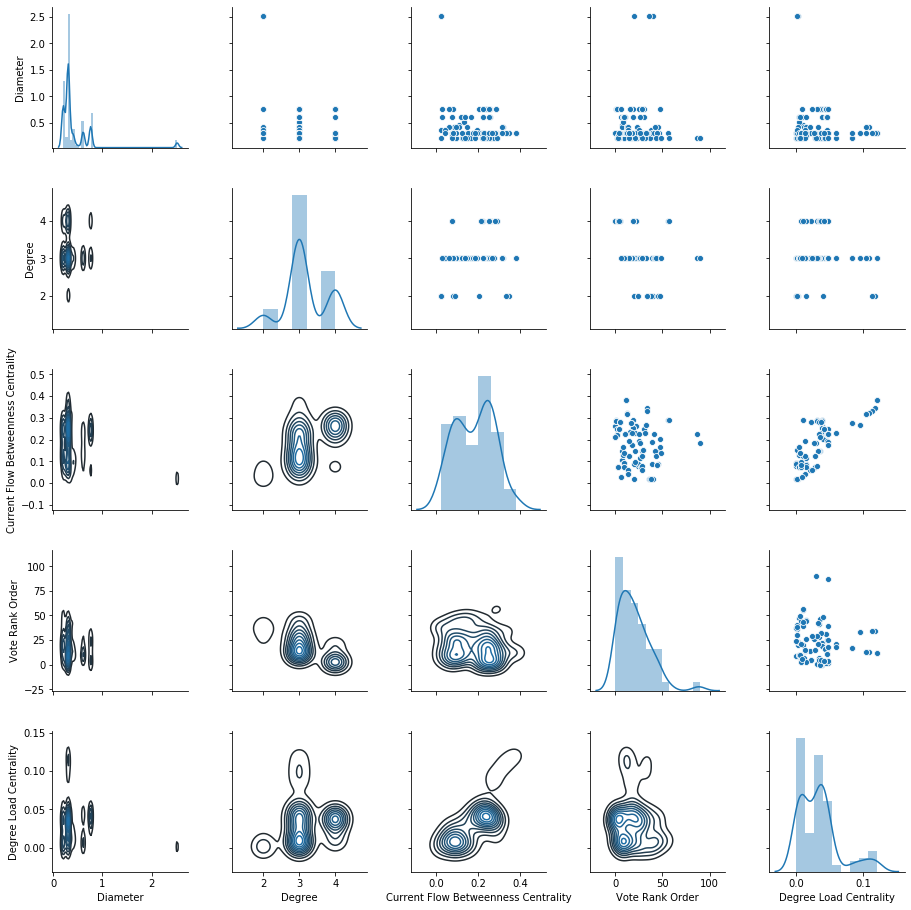

In [29]:
g = sns.PairGrid(df_pipeStatistics, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)

In [30]:
df_pipeStatistics = waterNetwork.pipes[["diameter","highest_node_current_flow_betweenness_centrality","highest_node_vote_rank_order","highest_node_degree_load_centrality"]]
df_pipeStatistics.columns = ["Diameter","Current Flow Betweenness Centrality","Vote Rank Order","Degree Load Centrality"]

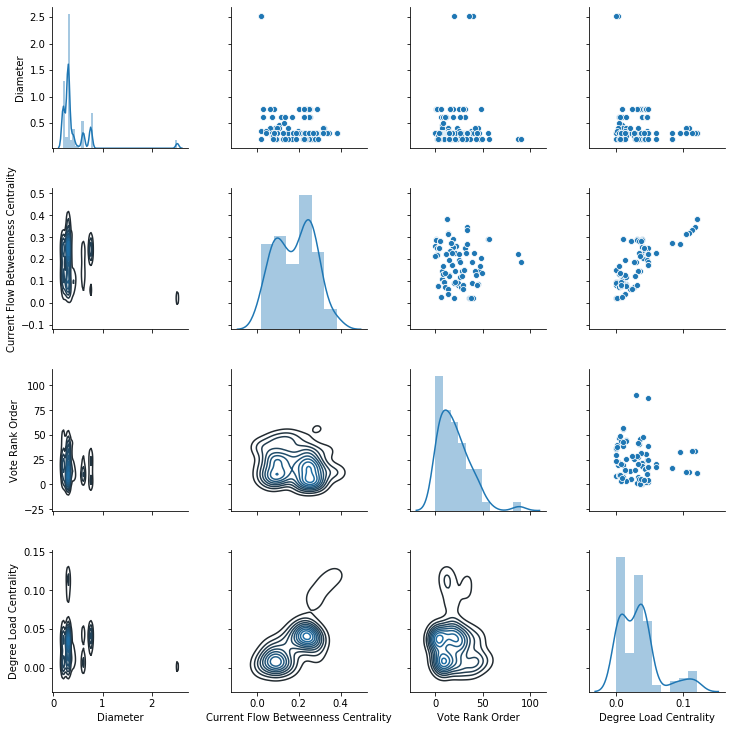

In [31]:
g = sns.PairGrid(df_pipeStatistics, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)

# Generate candidate lists of sensors based upon network statistics

In [70]:
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

In [71]:
nHighest = 10

## Set sensors based on n-highest vote ranks

In [ ]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

In [28]:
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_vote_rank_order").iloc[0:nHighest].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [29]:
results_VoteRank = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=1000)
acceptanceRate = np.sum(results_VoteRank["isAccepted"])/len(results_VoteRank["isAccepted"])
savePickle(results_VoteRank,"results_VoteRank.pkl")

 [████████████████████████████████████████████████████████████] 1000/1000 [05:23<00:00, 0.32s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



(<matplotlib.axes._subplots.AxesSubplot at 0x2161a48abc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2161a474708>)

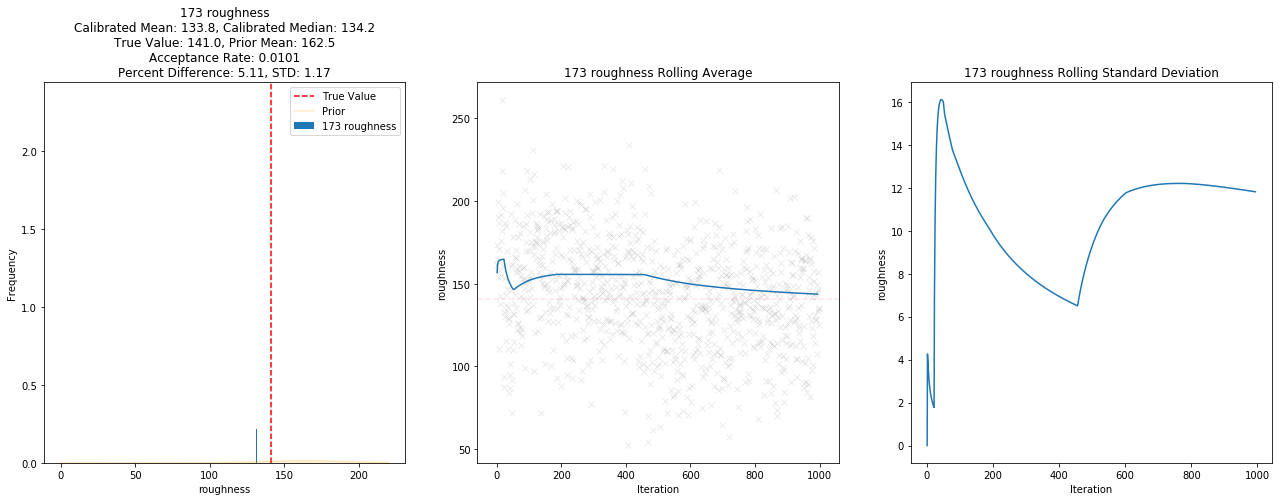

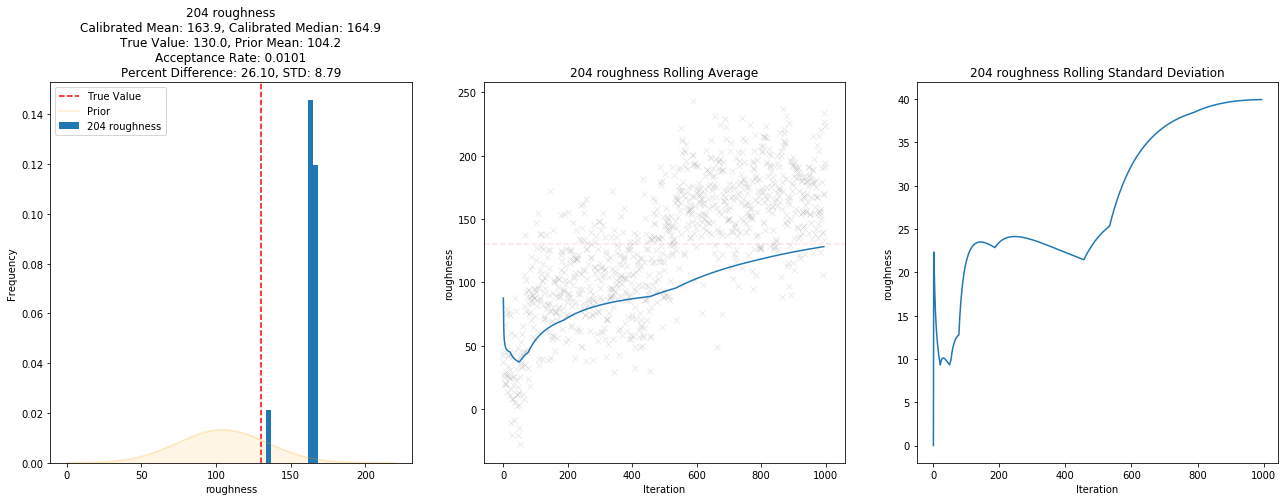

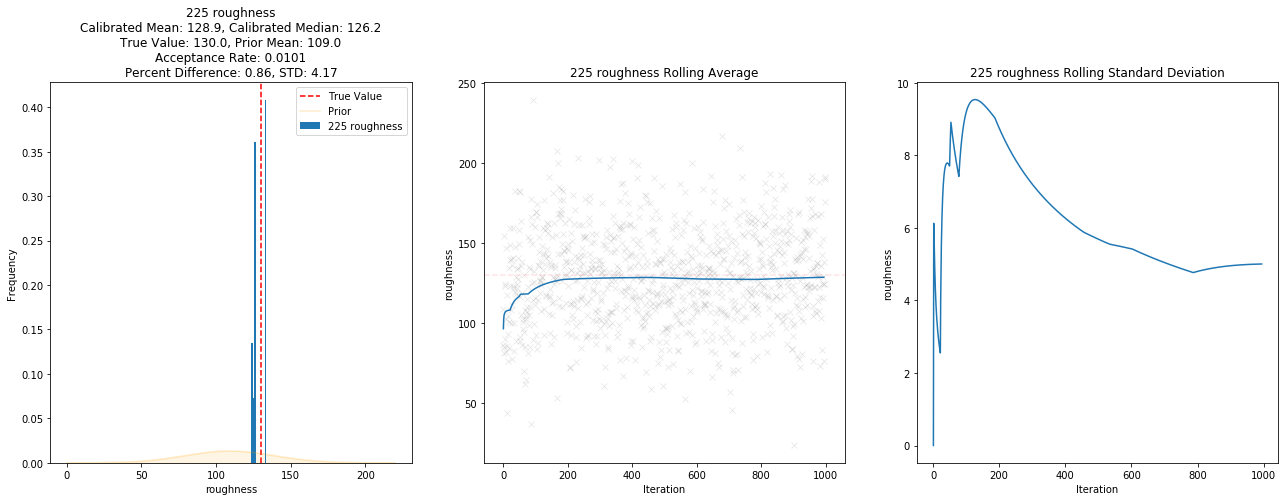

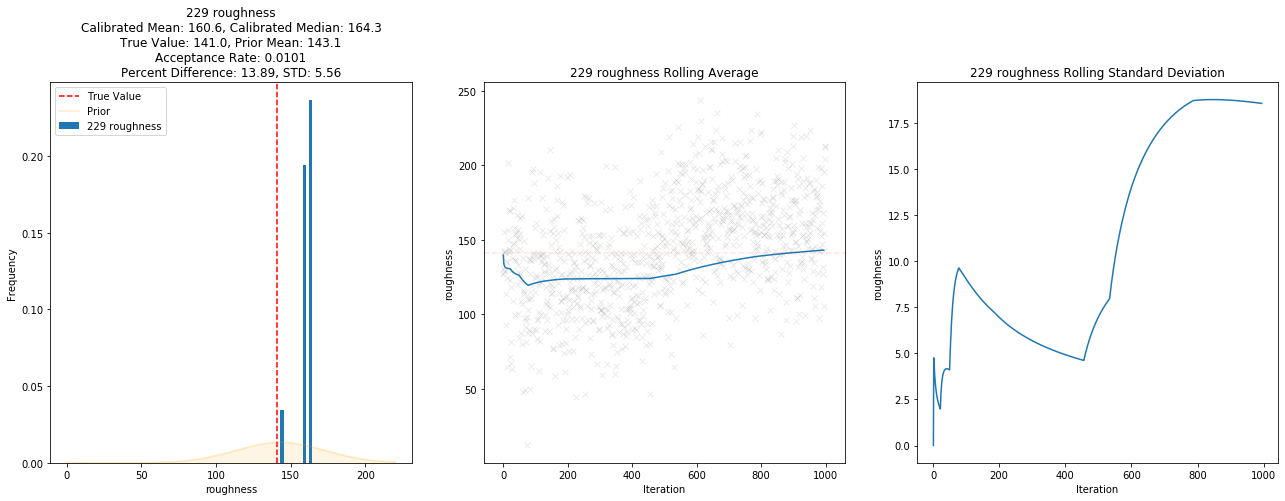

In [30]:
plotCalibratorResults(listOfCalibrators,burnin=0.5,acceptanceRate=acceptanceRate)

## Set senors based on highest node degree

In [ ]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

In [31]:
waterNetwork.generateNetworkStatistics()
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_degree").iloc[0:nHighest].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [32]:
results_NodeDegree = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=1000)
acceptanceRate = np.sum(results_NodeDegree["isAccepted"])/len(results_NodeDegree["isAccepted"])
savePickle(results_NodeDegree,"results_NodeDegree.pkl")

 [████████████████████████████████████████████████████████████] 1000/1000 [04:41<00:00, 0.28s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



(<matplotlib.axes._subplots.AxesSubplot at 0x2161a307dc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x216313cafc8>)

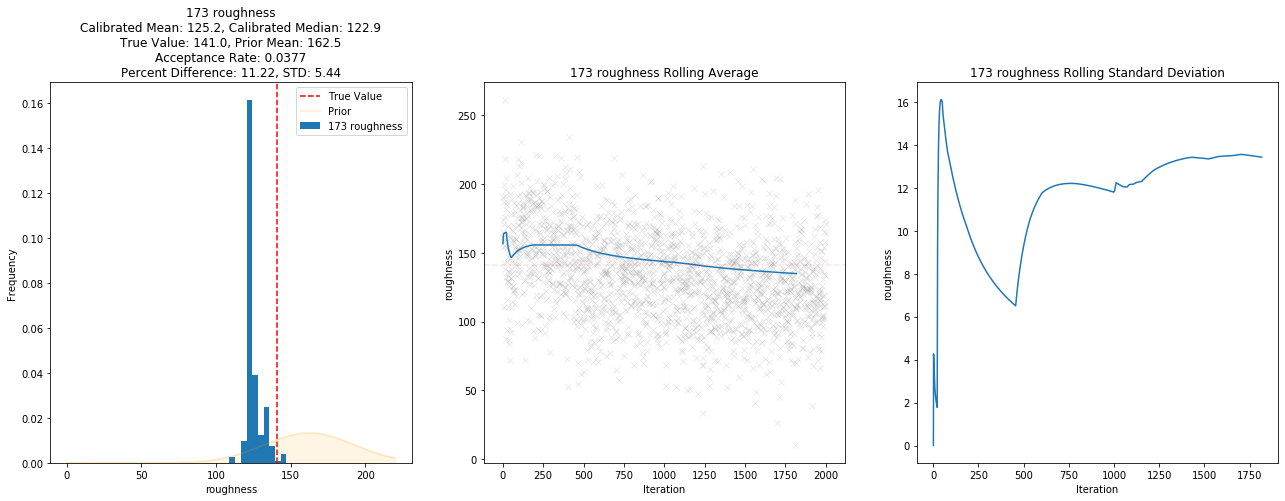

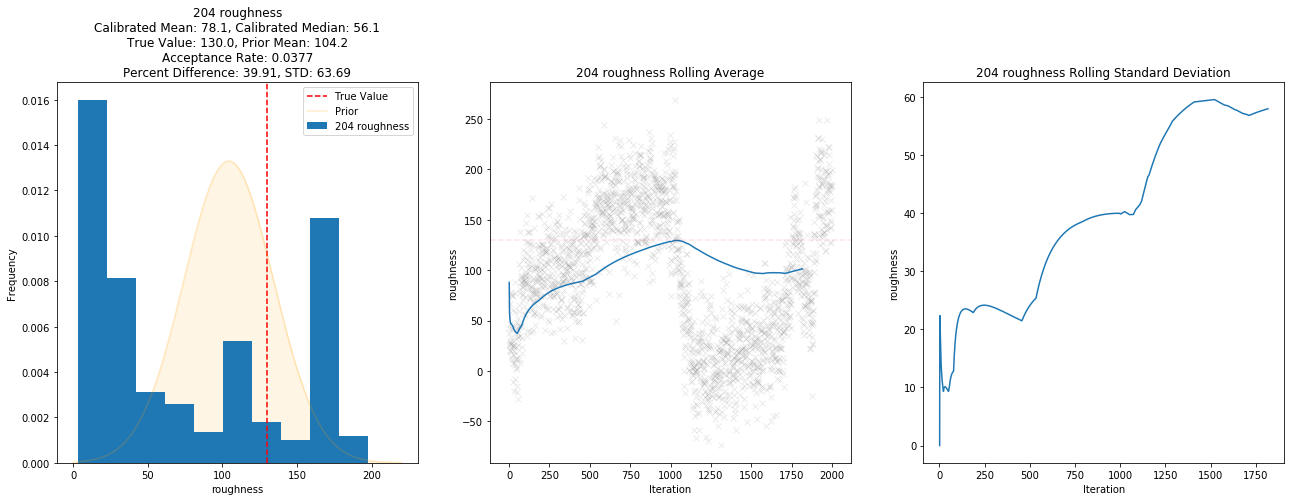

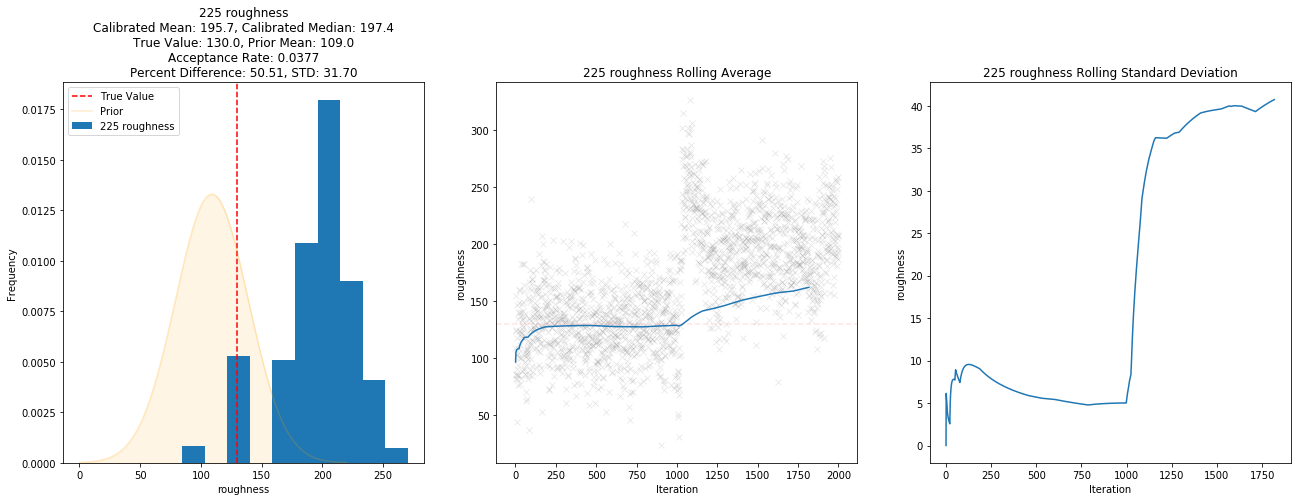

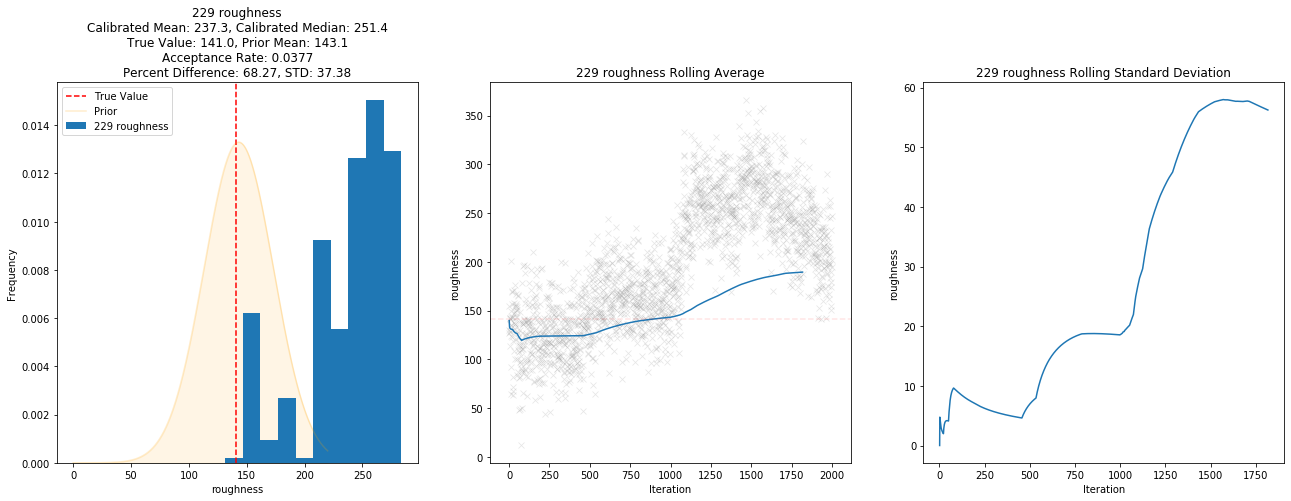

In [33]:
plotCalibratorResults(listOfCalibrators,burnin=0.5,acceptanceRate=acceptanceRate)

## Set sensors based on highest node degree centrality

In [ ]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

In [72]:
waterNetwork.generateNetworkStatistics()
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_current_flow_betweenness_centrality").iloc[0:nHighest].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [73]:
results_NodeDegreeCentrality = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=100)
acceptanceRate = np.sum(results_NodeDegreeCentrality["isAccepted"])/len(results_NodeDegreeCentrality["isAccepted"])
savePickle(results_NodeDegreeCentrality,"results_NodeDegreeCentrality.pkl")

 [████████████████████████████████████████████████████████████] 100/100 [00:32<00:00, 0.32s/it]

(<matplotlib.axes._subplots.AxesSubplot at 0x2163116a848>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21631785088>)

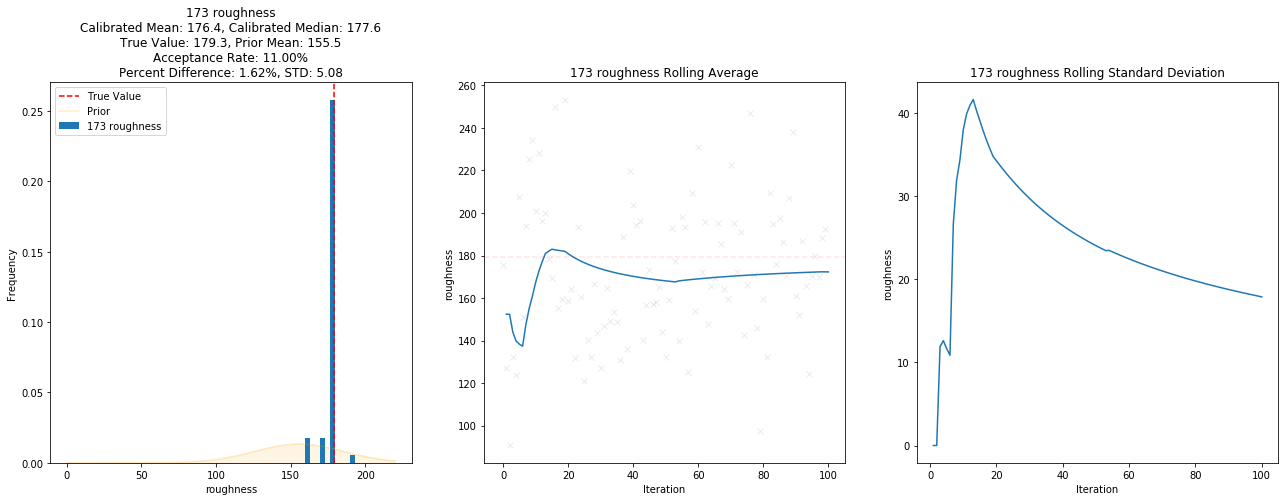

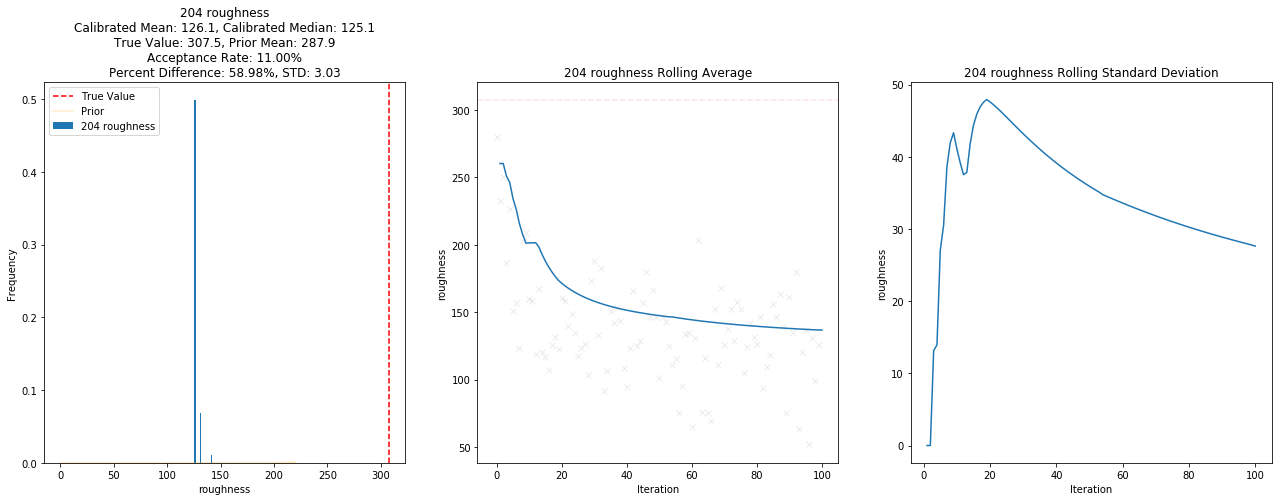

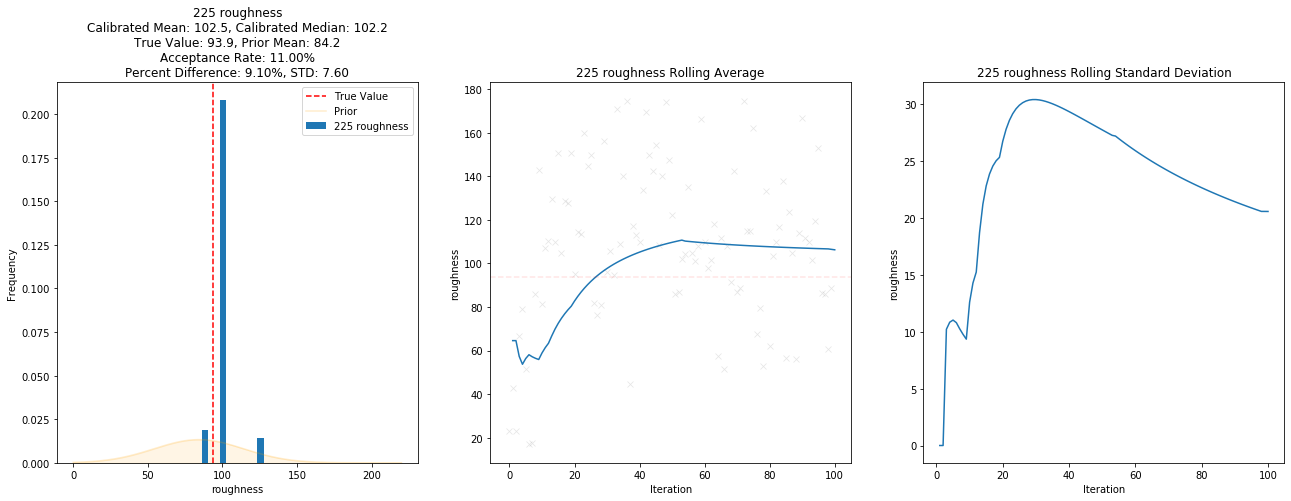

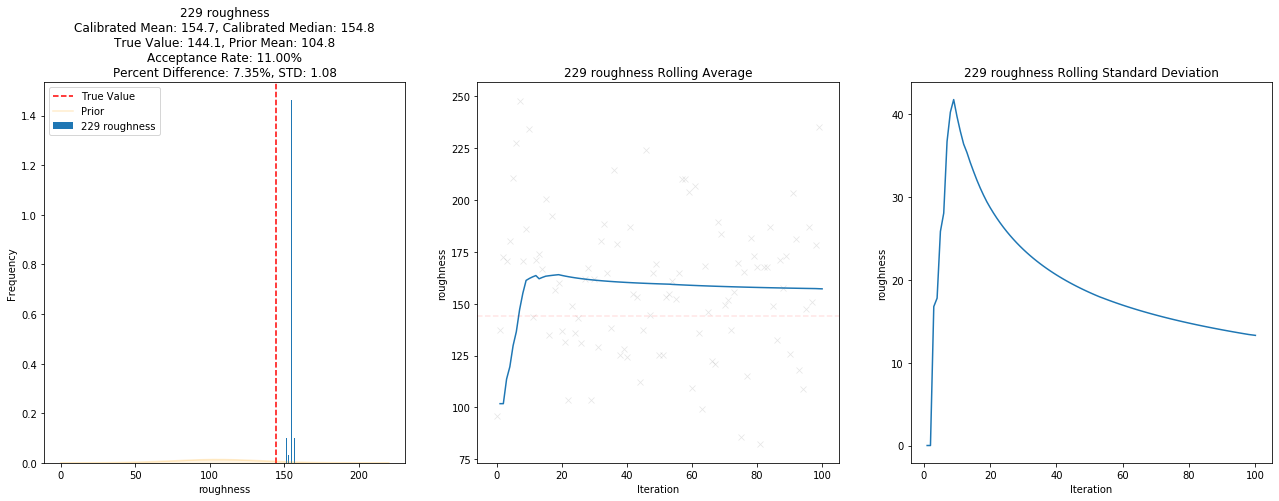

In [74]:
plotCalibratorResults(listOfCalibrators,burnin=0.5,acceptanceRate=acceptanceRate)

# Generate candidate lists of sensors based upon calibrator locations

## Set sensors at each calibrator

In [ ]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

In [269]:
pipesToSense = ["204","225","229","173"]
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [ ]:
results_SenseCalibrators = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=1000)
acceptanceRate = np.sum(results_SenseCalibrators["isAccepted"])/len(results_SenseCalibrators["isAccepted"])
savePickle(results_SenseCalibrators,"results_SenseCalibrators.pkl")

In [ ]:
plotCalibratorResults(listOfCalibrators,burnin=0.5,acceptanceRate=acceptanceRate)

# Markov Chain Monte Carlo

In [40]:
listOfSensors = generateListOfSensors(waterNetwork,["205","120","269","149"])

In [41]:
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)
# listOfSensors = generateRandomSensors(waterNetwork)

In [42]:
resultsDict = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=10000)

 [████████████████████████████████████████████████████████████] 10000/10000 [40:01<00:00, 0.24s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



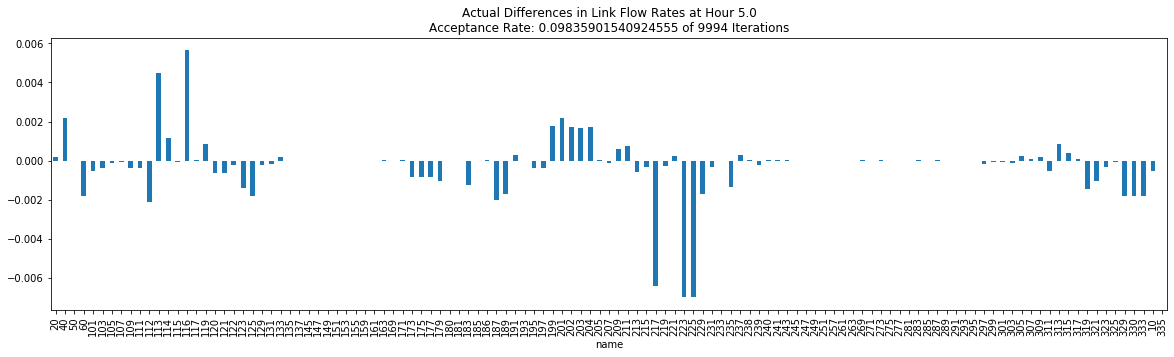

In [43]:
plotDifferencesInResults(resultsDict)

(<matplotlib.axes._subplots.AxesSubplot at 0x22d269f3f48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22d26a1b3c8>)

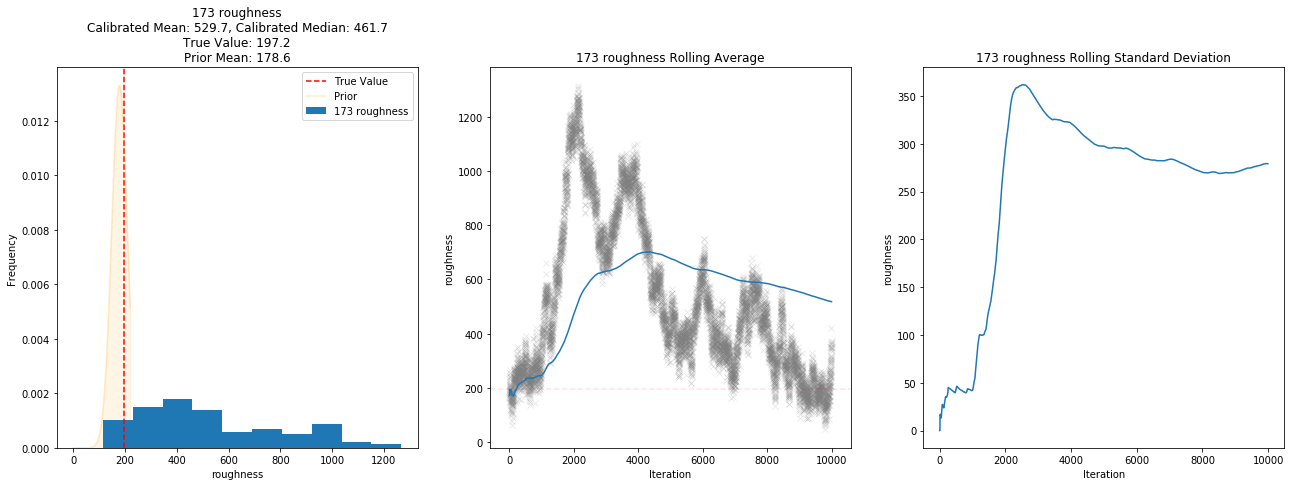

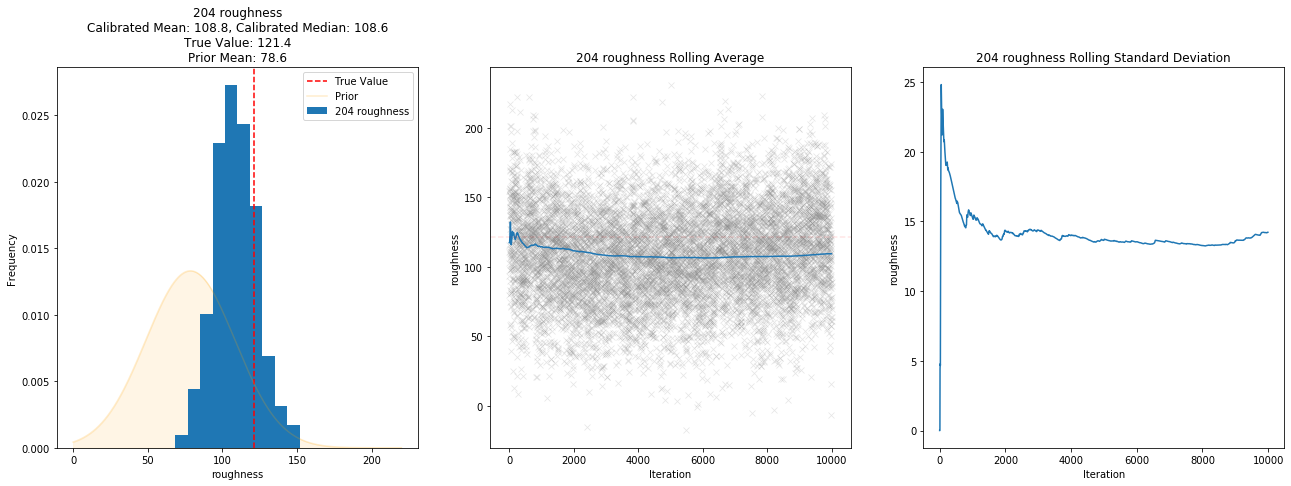

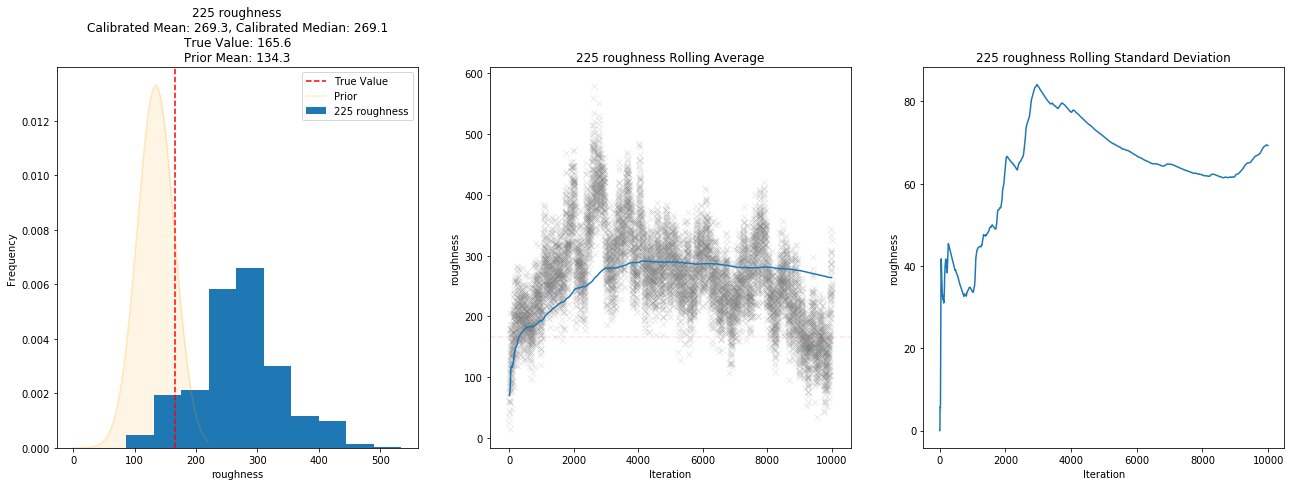

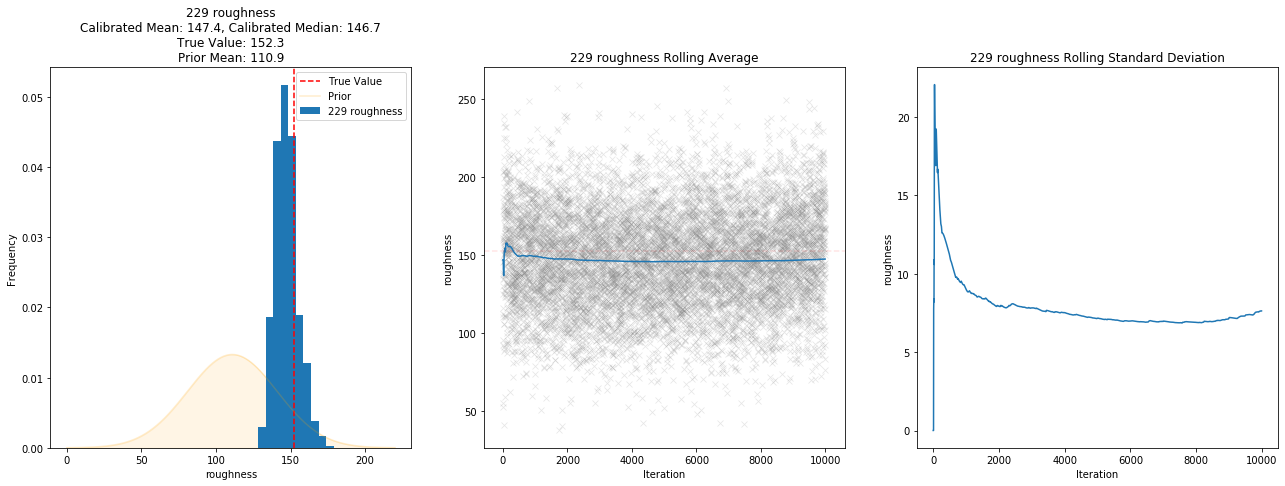

In [44]:
plotCalibratorResults(listOfCalibrators)

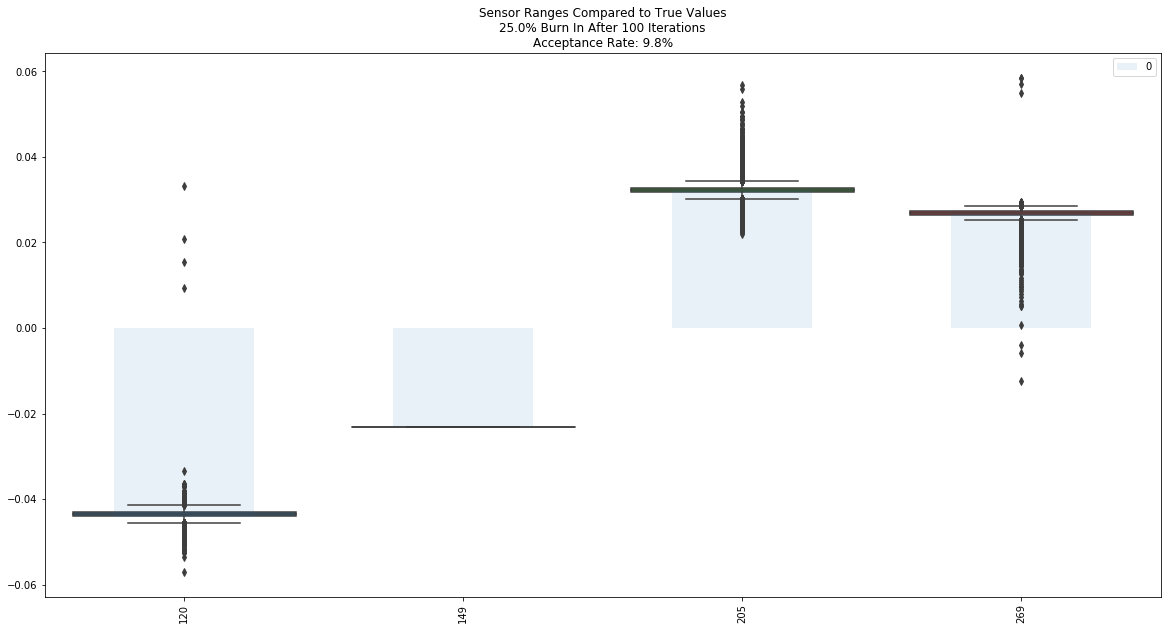

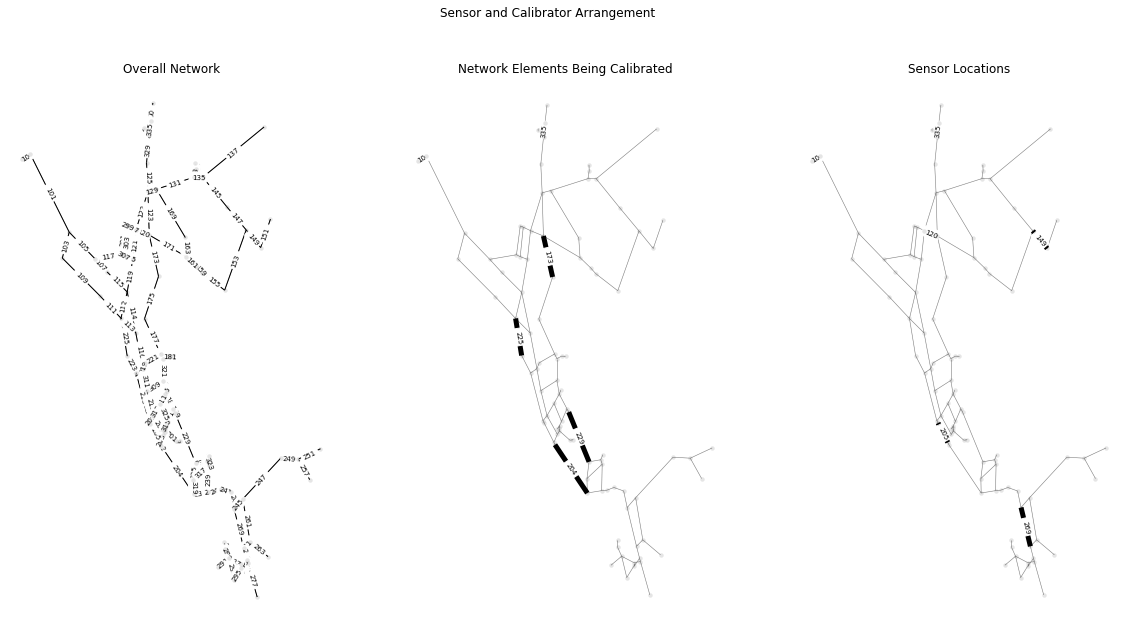

In [48]:
plotNetworkSetup(resultsDict)

In [46]:
savePickle({"name":"10,000 iterations with 4 manual sensors","listOfSensors":listOfSensors,"listOfCalibrators":listOfCalibrators},"trial2.pkl")

In [ ]:
testResults = loadPickle("trial1.pkl")